In [ ]:
import ROOT
import uproot
import math
import time
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gcsh
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_scatter import scatter_max, scatter_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

In [2]:
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=5.0  # mm
SamplingLayer=30
ECAL_layers=60
Threshold=Threshold_i*MIP_table[Si]
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,Z_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        Z_layers_all = np.vstack((Z_layers_all, np.vstack(Z_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, Z_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        Z_layers_all = np.vstack((Z_layers_all, Z_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    Z_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        posZ = pos_z[i_event].to_numpy()
        Z_layers_event = np.bincount(layers, weights=posZ*energies, minlength=ECAL_layers)
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        Z_layers.append(Z_layers_event/E_layers_event.clip(min=1e-6))
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,Z_layers,E_truth_flat
#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
E_layers_test, N_layers_test, Z_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_la

length after zero suppression: 1249735 1249735 1249735 1249735 1249735 1249735
length after event selection: 1249735
length after zero suppression: 59997 59997 59997 59997 59997 59997
length after event selection: 59997
length of E_truth_test: 59997


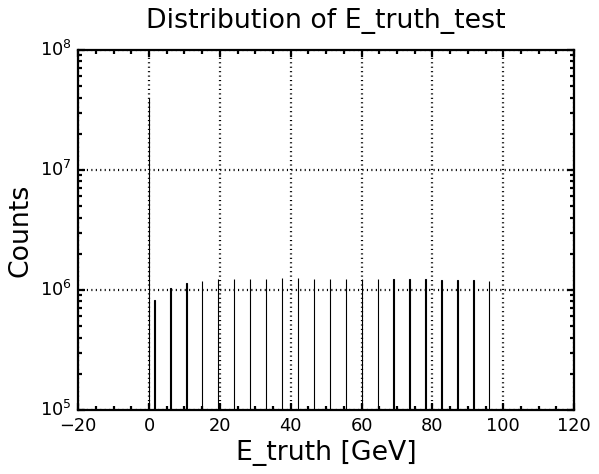

length after event selection: 59997 59997 59997 59997 59997 59997


In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers, Z_layers, E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    Z_sum = np.array([np.sum(z) for z in Z_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]
    Z_layers_filtered = [Z_layers[i] for i in range(len(Z_layers)) if mask[i]]
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(Z_layers_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, Z_layers_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,Z_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth = zero_suppression(E_layers, N_layers, Z_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    Z_layers = np.array([start_from_shower_layer(ev) for ev in Z_layers])
    print("length after event selection:", len(E_layers))
    return E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, Z_layers_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, Z_layers_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, Z_layers_test, E_truth_test)
#Draw E_truth
print("length of E_truth_test:", len(E_truth_test))
plt.figure(figsize=fig_size)
plt.hist(Z_layers_uniform.flatten(), bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
print("length after event selection:", len(E_layers_test), len(N_layers_test), len(E_sum_test), len(N_sum_test), len(Z_layers_test), len(E_truth_test))

In [4]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [5]:
def ScaleFeatures(Features_train, Features_test):
    scaler = StandardScaler().fit(Features_train)
    Features_train_scaled = scaler.transform(Features_train)
    Features_test_scaled  = scaler.transform(Features_test)
    return Features_train_scaled, Features_test_scaled

E_layers_uniform_scaled, E_layers_test_scaled = ScaleFeatures(E_layers_uniform, E_layers_test)
N_layers_uniform_scaled, N_layers_test_scaled = ScaleFeatures(N_layers_uniform, N_layers_test)
Z_layers_uniform_scaled, Z_layers_test_scaled = ScaleFeatures(Z_layers_uniform, Z_layers_test)
E_N_layers_uniform_scaled, E_N_layers_test_scaled = ScaleFeatures(E_N_layers_uniform, E_N_layers_test)
E_layers_uniform_ratio_scaled, E_layers_test_ratio_scaled = ScaleFeatures(E_layers_uniform_ratio, E_layers_test_ratio)
N_layers_uniform_ratio_scaled, N_layers_test_ratio_scaled = ScaleFeatures(N_layers_uniform_ratio, N_layers_test_ratio)

extra_features_train = np.hstack([
    E_layers_uniform,
    N_layers_uniform,
    E_layers_uniform_ratio,
    E_sum_uniform[:, np.newaxis],
    N_layers_uniform_ratio,
    N_sum_uniform[:, np.newaxis],
    E_N_layers_uniform,
    #LayerNum_uniform,
    #Average_E_layer_uniform,
    #Average_N_layer_uniform
])

extra_features_test = np.hstack([
    E_layers_test,
    N_layers_test,
    E_layers_test_ratio,
    E_sum_test[:, np.newaxis],
    N_layers_test_ratio,
    N_sum_test[:, np.newaxis],
    E_N_layers_test,
    #LayerNum_test,
    #Average_E_layer_test,
    #Average_N_layer_test
])
extra_features_train, extra_features_test = ScaleFeatures(extra_features_train, extra_features_test)

In [6]:
def make_event_graph_list(conv_features, pos_features, y_true, extra_features=None, k=3):
    print("shape:", conv_features.shape, pos_features.shape, y_true.shape)
    n_events, n_nodes = conv_features.shape[:2]
    data_list = []
    conv_features = torch.tensor(conv_features, dtype=torch.float32)
    pos_features  = torch.tensor(pos_features, dtype=torch.float32)
    y_true        = torch.tensor(y_true, dtype=torch.float32)
    if extra_features is not None:
        extra_features = torch.tensor(extra_features, dtype=torch.float32)
    for i in range(n_events):
        x_conv = conv_features[i]  # (n_nodes, conv_dim)
        pos    = pos_features[i]   # (n_nodes,) or (n_nodes, pos_dim)
        x = torch.cat([x_conv, pos], dim=-1)  # (n_nodes, conv_dim+pos_dim)
        edge_index = knn_graph(pos, k=k, loop=False)
        label = y_true[i]
        extra = extra_features[i].unsqueeze(0) if extra_features is not None else None
        data = Data(
            x=x,
            edge_index=edge_index,
            y=label,
            extra=extra,
        )
        data_list.append(data)
    return data_list

def get_batch_size(device):
    if device.type == "cuda":
        total_mem = torch.cuda.get_device_properties(device).total_memory / (1024**3)  # GB
        if total_mem < 8:
            return 256
        elif total_mem < 16:
            return 1024
        else:
            return 2048
    else:
        return 128
conv_features_train = np.stack([E_layers_uniform_scaled, N_layers_uniform_scaled,E_N_layers_uniform_scaled], axis=-1)
pos_features_train = Z_layers_uniform_scaled[..., np.newaxis]
conv_features_test = np.stack([E_layers_test_scaled, N_layers_test_scaled,E_N_layers_test_scaled], axis=-1)
pos_features_test = Z_layers_test_scaled[..., np.newaxis]
conv_dim = conv_features_train.shape[-1]
pos_dim = pos_features_train.shape[-1]
print("shape:", conv_features_train.shape, pos_features_train.shape, extra_features_train.shape)
print("conv dim:", conv_dim, "pos dim:", pos_dim)
y_train_true = E_truth_uniform
y_test_true = E_truth_test
KNN_K=3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = get_batch_size(device)
batch_size = 4096 # for llrui02
print("Using device:", device, "with batch size:", batch_size)
data_list_train = make_event_graph_list(
    conv_features=conv_features_train,
    pos_features=pos_features_train,
    y_true=y_train_true,
    extra_features=extra_features_train,
    k=KNN_K,
)

data_list_test  = make_event_graph_list(
    conv_features=conv_features_test,
    pos_features=pos_features_test,
    y_true=y_test_true,
    extra_features=extra_features_test,
    k=KNN_K,
)
val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_train, test_size=val_split, random_state=random_state)


shape: (1249735, 60, 3) (1249735, 60, 1) (1249735, 302)
conv dim: 3 pos dim: 1
Using device: cuda with batch size: 4096
shape: (1249735, 60, 3) (1249735, 60, 1) (1249735,)
shape: (59997, 60, 3) (59997, 60, 1) (59997,)


In [7]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #base = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #loss = base * (1 + abs_rel)
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * (abs_rel - self.delta + self.delta**2))
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class EdgeConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
    def forward(self, x, edge_index):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        edge_feat = torch.cat([x_i, x_j - x_i], dim=-1)
        out = self.mlp(edge_feat)
        #out,_ = scatter_max(out, row, dim=0, dim_size=x.size(0))
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        return out

class DGCNN_MLP(nn.Module):
    def __init__(self, EdgeMLP_hidden=[[128,128],[64,64]], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.edge_convs = nn.ModuleList()
        for hidden in EdgeMLP_hidden:
            self.edge_convs.append(
                EdgeConv(hidden_layers=hidden, dropout=dropout, activation=activation)
            )
        print(f"Edge MLP hidden dims per layer: {EdgeMLP_hidden}, Dropout: {dropout}, Activation: {activation}")

        print(f"MLP hidden dims: {mlp_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        print(f"Output layer: Linear({mlp_hidden[-1]} -> 1)")
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, data):
        x = data.x
        for conv in self.edge_convs:
            x = conv(x, data.edge_index)
        x = global_mean_pool(x, data.batch)
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x
        out = self.mlp(combined)
        out = self.energy_output_layer(out).squeeze(-1)
        return out




In [8]:
def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = PyGDataLoader(data_list_train, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(data_list_val, batch_size=batch_size, shuffle=False)

    # Model
    model = DGCNN_MLP(
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (epochs/50) * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}｜ patience: {patience_counter}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred,best_val_loss

Using device: cuda
Random state: 42
Training samples: 999788, Validation samples: 249947
learning rate: 0.0005, batch size: 4096, epochs: 500, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [32, 32, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [64, 64, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Edge MLP hidden dims per layer: [[32, 32, 32], [64, 64, 64]], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Output layer: Linear(64 -> 1)
MLP input dim: 8
MLP input dim: 64
MLP input dim: 366
Epoch 001/500 | Train Loss: 0.038438 | Val Loss: 0.019311| LR: 0.000200｜ patience: 0
Epoch 002/500 | Train Loss: 0.006429 | Val Loss: 0.002148| LR: 0.000300｜ patience: 0
Epoch 003/500 | Train Loss: 0.003567 | Val Loss: 0.001985| LR: 0.000400｜ patience: 0
Epoch 004/500 | Train Loss: 0.003069 | Val

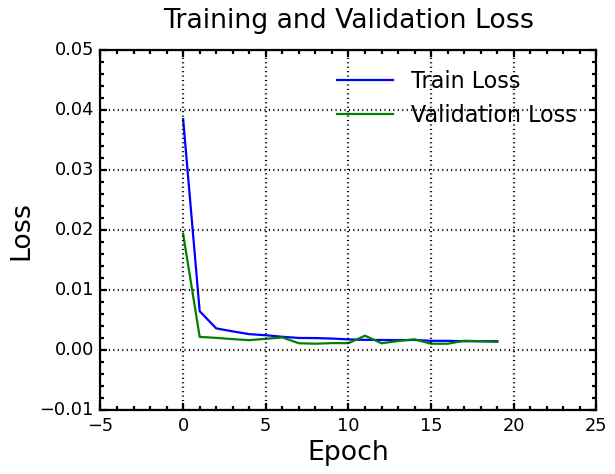

In [ ]:
CONF_NAME="0.5Data"
dgcnn_model, y_val_true, y_val_pred, best_val_loss = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    EdgeMLP_dims=[[32,32,32],[64,64,64]],
    mlp_dims=[256, 128, 64],
    dropout=0.1,
    lr=5e-4,
    weight_decay=1e-8,
    batch_size=batch_size,
    epochs=500,
    patience=10,
    val_split=0.2,
    random_state=random_state
)
torch.save(dgcnn_model, DataPath_Validate+f"/Models/DGCNN.pth")
# Evaluate on test set

Step 1 Linear fit coeffs: [ 0.00060391 -0.05338029]


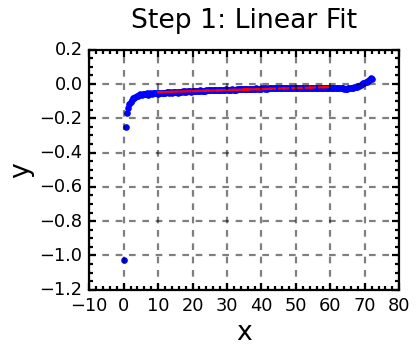

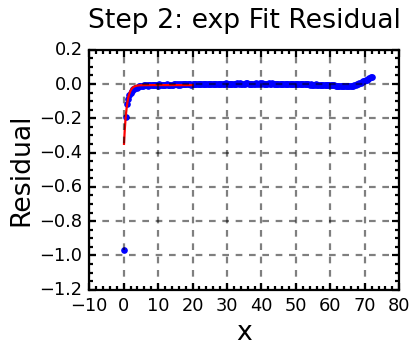

Step 3 Linear fit coeffs: [ 0.00121407 -0.05947039]


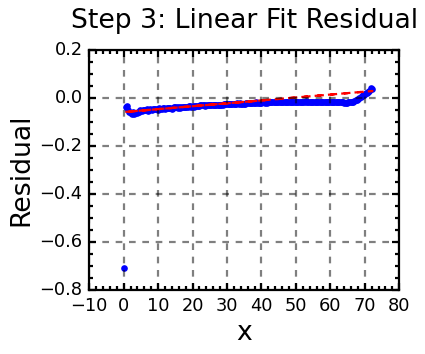

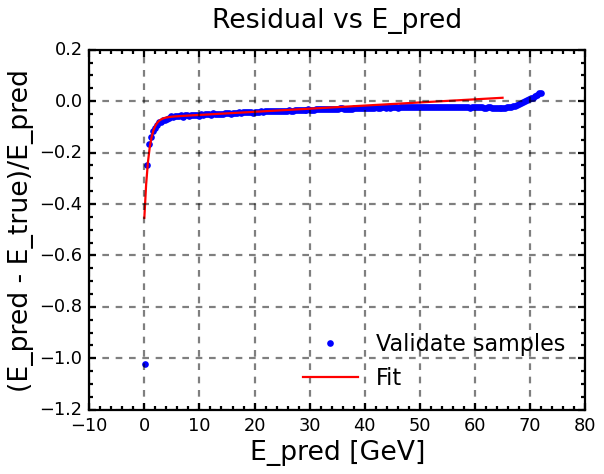

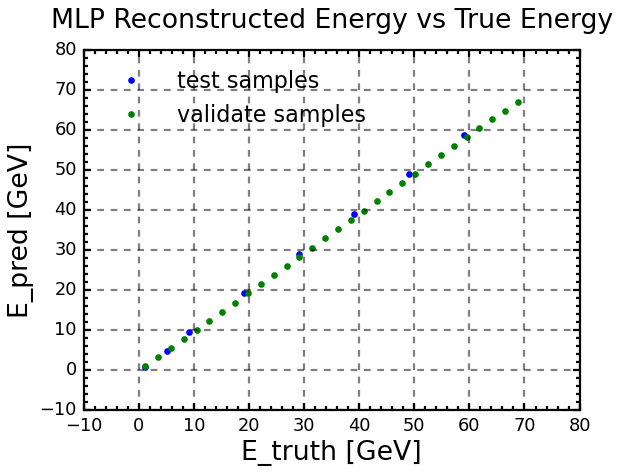

In [30]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (0.1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = PyGDataLoader(data_list_test, batch_size=batch_size, shuffle=False)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, E_truth_test, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

fit_range = (0, 65) 
mask = y_val_pred>0
residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred_calib, E_truth_test, Energy_test, Nbins=100)
Reco_hist_all.append(Reco_hist)

plt.figure(figsize=fig_size)
plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [31]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 10.049867644095647, Peak: 10.219956641168842, RMS: 0.5282955321926518
Initial Gamma Fit Parameters: [np.float64(233.25591980001352), np.float64(4.8469910271244405), np.float64(7.489223939887933), np.float64(0.5282955321926518)]
Gamma Fit Bounds: lower [np.float64(2.3325591980001352), np.float64(-0.5153008972875559), np.float64(-0.25107760601120666), np.float64(0.052829553219265184)], 
 upper [np.float64(1399.535518800081), np.float64(48.4699102712444), np.float64(21.2338359098319), np.float64(5.282955321926518)]


Gamma Fit Parameters: [2.31745130e+02 4.84699103e+01 6.47581254e+00 7.44470424e-02]
Gamma Fit Peak: 10.009806961169055 ± 0.01068811697229072, Mean: 10.084254003534062 ± 0.01077932924569925, Resolution: 0.051779500234665404 ± 0.000737023499777746


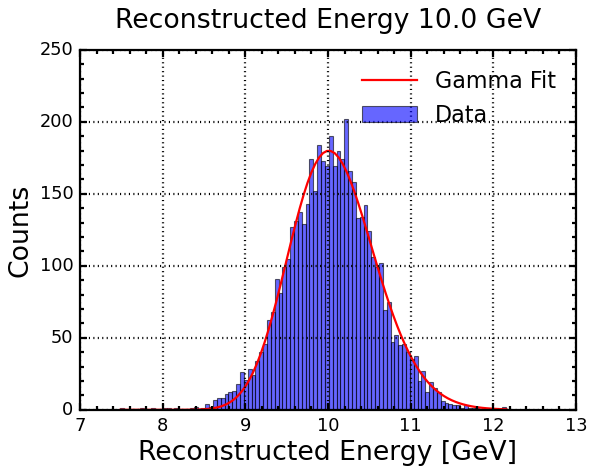

In [32]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Saving fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/Reco_Results/RecoE_DGCNN_[256]_WD1e-8_Fit.csv
Mean: 0.09001510105747888, Peak: 0.09759413463066469, RMS: 0.0692145998802659
Initial Gamma Fit Parameters: [np.float64(52.74172208799235), np.float64(6.692731520733403), np.float64(-0.37321963325612717), np.float64(0.0692145998802659)]
Gamma Fit Bounds: lower [np.float64(0.5274172208799235), np.float64(-0.33072684792665963), np.float64(-1.0373219633256128), np.float64(0.006921459988026591)], 
 upper [np.float64(316.4503325279541), np.float64(66.92731520733403), np.float64(9.440170550115809), np.float64(0.692145998802659)]
Gamma Fit Parameters: [ 5.22344511e+01  6.69273152e+01 -4.28688183e-01  7.76628852e-03]
Gamma Fit Peak: 0.08332236757738837 ± 0.0011476729949028057, Mean: 0.09108865609808031 ± 0.00115500811958693, Resolution: 0.7625241811998816 ± 0.015145882401668335


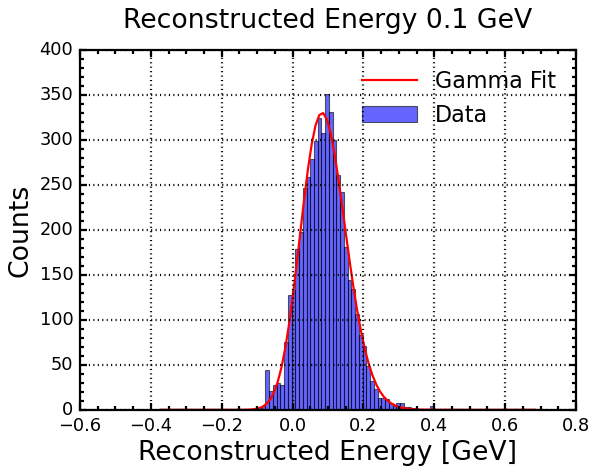

appending results for E = 0.1
Mean_Gamma: 0.09108865609808031 Mean_Gamma_Error: 0.00115500811958693
Peak_Gamma: 0.08332236757738837 Peak_Gamma_Error: 0.0011476729949028057
Mean: 0.27002527658989317, Peak: 0.2669572385179812, RMS: 0.07994158648597469
Initial Gamma Fit Parameters: [np.float64(34.22047404421163), np.float64(4.109914977133866), np.float64(-0.05852784700465645), np.float64(0.07994158648597469)]
Gamma Fit Bounds: lower [np.float64(0.3422047404421163), np.float64(-0.5890085022866134), np.float64(-1.0058527847004657), np.float64(0.007994158648597469)], 
 upper [np.float64(205.32284426526977), np.float64(41.09914977133866), np.float64(9.912208229493014), np.float64(0.7994158648597469)]
Gamma Fit Parameters: [ 3.38248229e+01  4.10991498e+01 -2.17794509e-01  1.18499197e-02]
Gamma Fit Peak: 0.2573771962025895 ± 0.0014244215071931748, Mean: 0.26922711592061255 ± 0.0014387854459390478, Resolution: 0.2951628950353078 ± 0.004456359122356691


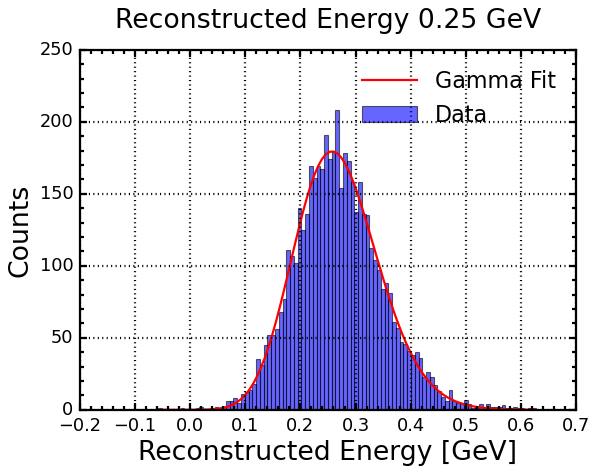

appending results for E = 0.25
Mean_Gamma: 0.26922711592061255 Mean_Gamma_Error: 0.0014387854459390478
Peak_Gamma: 0.2573771962025895 Peak_Gamma_Error: 0.0014244215071931748
Mean: 0.5312035372515672, Peak: 0.5105934526182996, RMS: 0.10870934354534928
Initial Gamma Fit Parameters: [np.float64(65.24134967757952), np.float64(5.535154269740135), np.float64(-0.07051944983411994), np.float64(0.10870934354534928)]
Gamma Fit Bounds: lower [np.float64(0.6524134967757952), np.float64(-0.44648457302598654), np.float64(-1.0070519449834119), np.float64(0.010870934354534928)], 
 upper [np.float64(391.4480980654771), np.float64(55.35154269740134), np.float64(9.89422082524882), np.float64(1.0870934354534927)]
Gamma Fit Parameters: [ 6.47542470e+01  3.03316224e+01 -4.58431589e-02  1.90150043e-02]
Gamma Fit Peak: 0.5118977679008508 ± 0.001674961363280841, Mean: 0.5309127722265048 ± 0.0016978215672348266, Resolution: 0.2045789819494369 ± 0.0025561706851276672


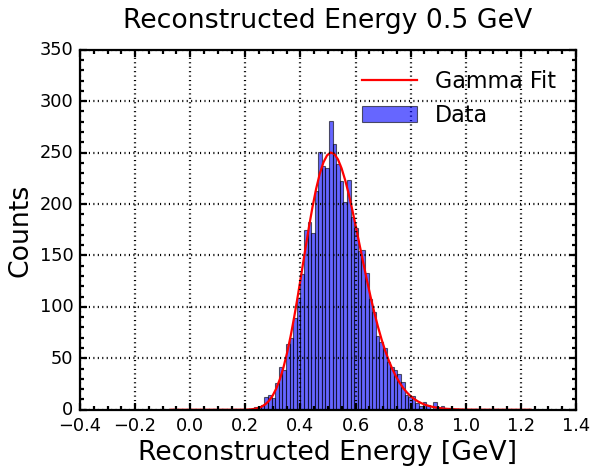

appending results for E = 0.5
Mean_Gamma: 0.5309127722265048 Mean_Gamma_Error: 0.0016978215672348266
Peak_Gamma: 0.5118977679008508 Peak_Gamma_Error: 0.001674961363280841
Mean: 1.040392785938335, Peak: 0.9996958968110942, RMS: 0.15842511547918825
Initial Gamma Fit Parameters: [np.float64(65.13586608073108), np.float64(3.9160842355658483), np.float64(0.419986688692587), np.float64(0.15842511547918825)]
Gamma Fit Bounds: lower [np.float64(0.6513586608073108), np.float64(-0.6083915764434151), np.float64(-0.9580013311307413), np.float64(0.015842511547918825)], 
 upper [np.float64(390.81519648438643), np.float64(39.16084235565848), np.float64(10.62998003303888), np.float64(1.5842511547918825)]
Gamma Fit Parameters: [6.50352311e+01 3.91608424e+01 5.72223368e-02 2.51772826e-02]
Gamma Fit Peak: 1.0180086475987595 ± 0.0033535203015839054, Mean: 1.043185930161578 ± 0.003388842827303298, Resolution: 0.15476879429121324 ± 0.0024347177417486945


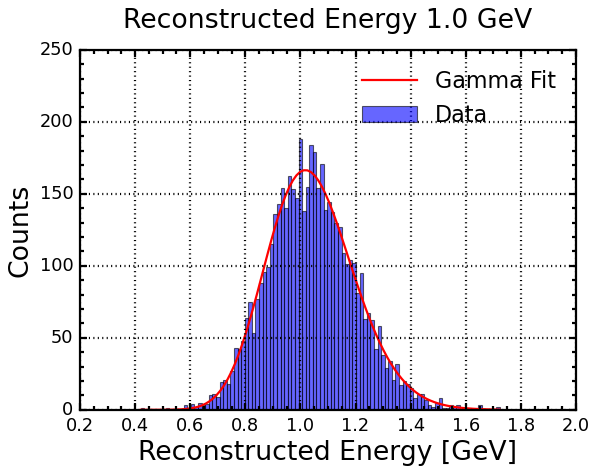

appending results for E = 1.0
Mean_Gamma: 1.043185930161578 Mean_Gamma_Error: 0.003388842827303298
Peak_Gamma: 1.0180086475987595 Peak_Gamma_Error: 0.0033535203015839054
Mean: 2.0147451016405573, Peak: 1.9927582527557244, RMS: 0.22181686137003254
Initial Gamma Fit Parameters: [np.float64(114.8779696905506), np.float64(3.0523076492956314), np.float64(1.3376917989380583), np.float64(0.22181686137003254)]
Gamma Fit Bounds: lower [np.float64(1.148779696905506), np.float64(-0.6947692350704369), np.float64(-0.8662308201061941), np.float64(0.022181686137003255)], 
 upper [np.float64(689.2678181433037), np.float64(30.523076492956314), np.float64(12.006537698407087), np.float64(2.2181686137003256)]
Gamma Fit Parameters: [1.15213637e+02 3.05230765e+01 7.82589848e-01 4.05531641e-02]
Gamma Fit Peak: 1.9798440145634344 ± 0.0033234927514153483, Mean: 2.0203971787075083 ± 0.003368502385561664, Resolution: 0.11316390438304279 ± 0.001241947101179429


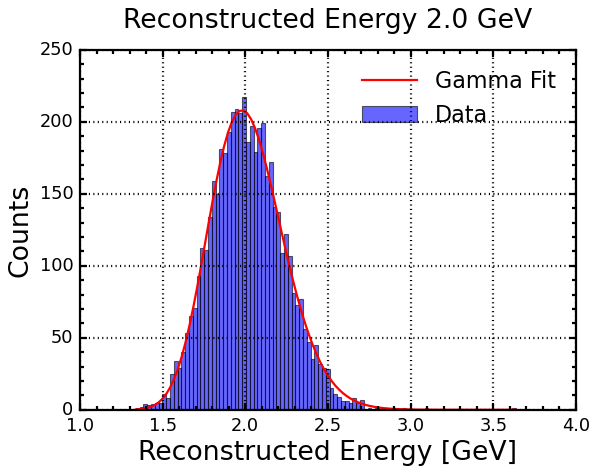

appending results for E = 2.0
Mean_Gamma: 2.0203971787075083 Mean_Gamma_Error: 0.003368502385561664
Peak_Gamma: 1.9798440145634344 Peak_Gamma_Error: 0.0033234927514153483
Mean: 5.020139773415573, Peak: 4.9816863399082205, RMS: 0.37369783331850825
Initial Gamma Fit Parameters: [np.float64(139.20778528207248), np.float64(3.1208691943970153), np.float64(3.85387771739893), np.float64(0.37369783331850825)]
Gamma Fit Bounds: lower [np.float64(1.3920778528207247), np.float64(-0.6879130805602984), np.float64(-0.614612228260107), np.float64(0.03736978333185083)], 
 upper [np.float64(835.2467116924349), np.float64(31.208691943970152), np.float64(15.780816576098395), np.float64(3.7369783331850828)]
Gamma Fit Parameters: [1.40701747e+02 3.12086919e+01 2.85668370e+00 7.00270479e-02]
Gamma Fit Peak: 4.972109212046693 ± 0.009733653074978702, Mean: 5.0421362599575374 ± 0.009863372752819517, Resolution: 0.07867974470294431 ± 0.0014197586389885163


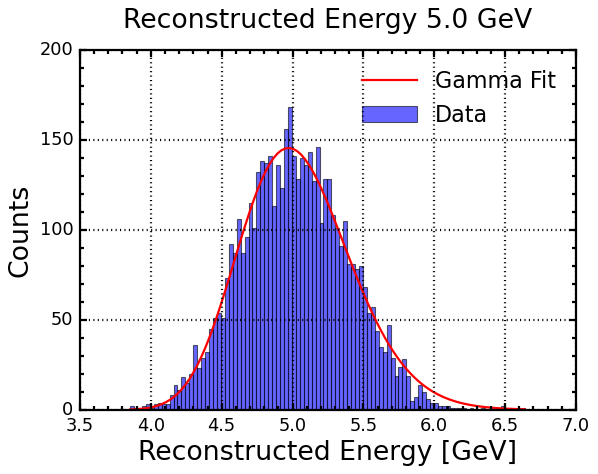

appending results for E = 5.0
Mean_Gamma: 5.0421362599575374 Mean_Gamma_Error: 0.009863372752819517
Peak_Gamma: 4.972109212046693 Peak_Gamma_Error: 0.009733653074978702
Mean: 10.049867644095647, Peak: 10.219956641168842, RMS: 0.5282955321926518
Initial Gamma Fit Parameters: [np.float64(233.25591980001352), np.float64(4.8469910271244405), np.float64(7.489223939887933), np.float64(0.5282955321926518)]
Gamma Fit Bounds: lower [np.float64(2.3325591980001352), np.float64(-0.5153008972875559), np.float64(-0.25107760601120666), np.float64(0.052829553219265184)], 
 upper [np.float64(1399.535518800081), np.float64(48.4699102712444), np.float64(21.2338359098319), np.float64(5.282955321926518)]
Gamma Fit Parameters: [2.31745130e+02 4.84699103e+01 6.47581254e+00 7.44470424e-02]
Gamma Fit Peak: 10.009806961169055 ± 0.01068811697229072, Mean: 10.084254003534062 ± 0.01077932924569925, Resolution: 0.051779500234665404 ± 0.000737023499777746


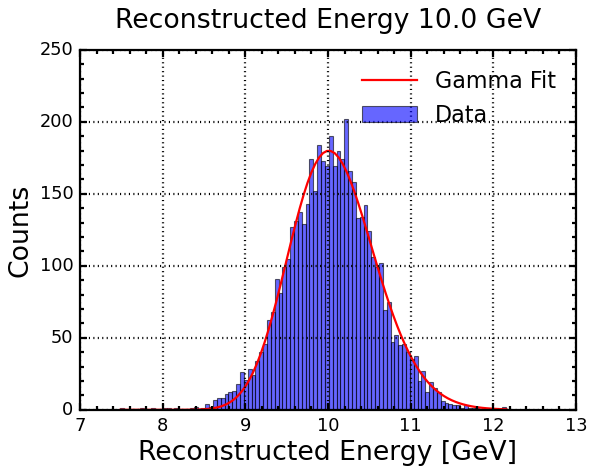

appending results for E = 10.0
Mean_Gamma: 10.084254003534062 Mean_Gamma_Error: 0.01077932924569925
Peak_Gamma: 10.009806961169055 Peak_Gamma_Error: 0.01068811697229072
Mean: 20.02681939593984, Peak: 19.823940276670953, RMS: 0.7516574437206136
Initial Gamma Fit Parameters: [np.float64(346.5991676283607), np.float64(5.022226342857002), np.float64(16.25182558128162), np.float64(0.7516574437206136)]
Gamma Fit Bounds: lower [np.float64(3.465991676283607), np.float64(-0.49777736571429976), np.float64(0.625182558128162), np.float64(0.07516574437206136)], 
 upper [np.float64(2079.5950057701643), np.float64(50.222263428570024), np.float64(34.377738371922426), np.float64(7.5165744372061365)]
Gamma Fit Parameters: [3.45067090e+02 5.02222634e+01 1.47918465e+01 1.04898842e-01]
Gamma Fit Peak: 19.95520496078403 ± 0.015284465996634794, Mean: 20.06010380249338 ± 0.015409149499570441, Resolution: 0.037253119093233894 ± 0.0005243729001791261


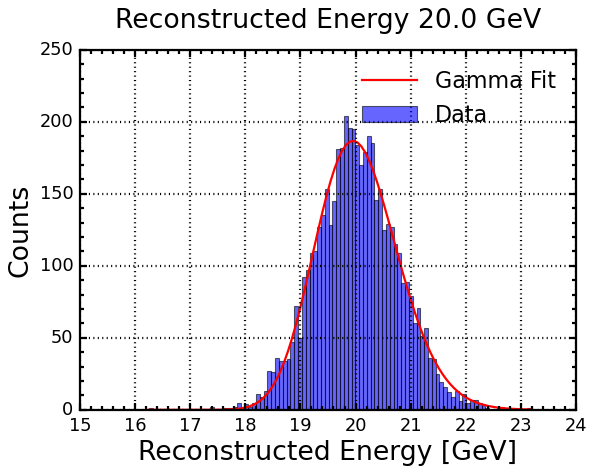

appending results for E = 20.0
Mean_Gamma: 20.06010380249338 Mean_Gamma_Error: 0.015409149499570441
Peak_Gamma: 19.95520496078403 Peak_Gamma_Error: 0.015284465996634794
Mean: 29.93871430993246, Peak: 29.789764110697714, RMS: 0.9368925611672708
Initial Gamma Fit Parameters: [np.float64(423.24673908271996), np.float64(5.448759035325419), np.float64(24.83381250214312), np.float64(0.9368925611672708)]
Gamma Fit Bounds: lower [np.float64(4.2324673908272), np.float64(-0.4551240964674581), np.float64(1.4833812502143124), np.float64(0.09368925611672708)], 
 upper [np.float64(2539.4804344963195), np.float64(54.48759035325419), np.float64(47.250718753214684), np.float64(9.368925611672708)]
Gamma Fit Parameters: [4.23954845e+02 5.44875904e+01 2.30311165e+01 1.27849326e-01]
Gamma Fit Peak: 29.86946889214491 ± 0.019030116200295953, Mean: 29.997318218122775 ± 0.019185268296683846, Resolution: 0.03159510066163752 ± 0.0004330794319812851


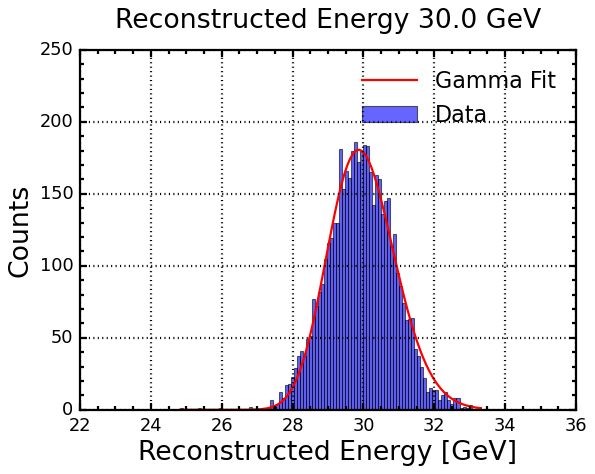

appending results for E = 30.0
Mean_Gamma: 29.997318218122775 Mean_Gamma_Error: 0.019185268296683846
Peak_Gamma: 29.86946889214491 Peak_Gamma_Error: 0.019030116200295953
Mean: 39.66623185293268, Peak: 39.40037664659903, RMS: 1.0636982812654932
Initial Gamma Fit Parameters: [np.float64(516.2400967614064), np.float64(4.669934521137616), np.float64(34.698830529176206), np.float64(1.0636982812654932)]
Gamma Fit Bounds: lower [np.float64(5.162400967614064), np.float64(-0.5330065478862384), np.float64(2.469883052917621), np.float64(0.10636982812654933)], 
 upper [np.float64(3097.4405805684387), np.float64(46.69934521137616), np.float64(62.04824579376431), np.float64(10.636982812654932)]
Gamma Fit Parameters: [5.15607229e+02 4.66993452e+01 3.24977174e+01 1.54945117e-01]
Gamma Fit Peak: 39.578607772351816 ± 0.017297757560143668, Mean: 39.73355288910256 ± 0.017448870759699135, Resolution: 0.026753017638324182 ± 0.0002995157209110744


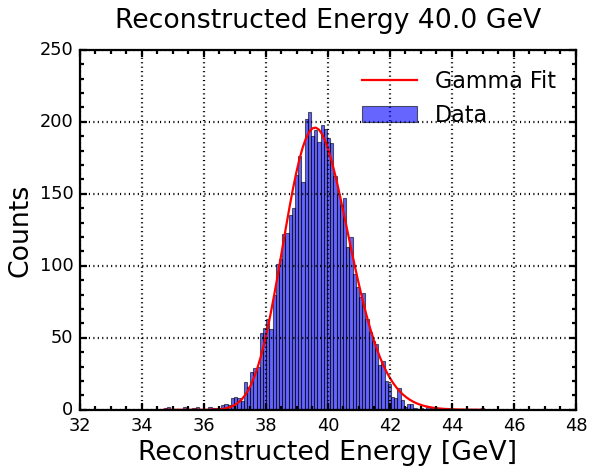

appending results for E = 40.0
Mean_Gamma: 39.73355288910256 Mean_Gamma_Error: 0.017448870759699135
Peak_Gamma: 39.578607772351816 Peak_Gamma_Error: 0.017297757560143668
Mean: 49.22168891463543, Peak: 48.82799489265555, RMS: 1.1366214963754353
Initial Gamma Fit Parameters: [np.float64(412.27011410370363), np.float64(3.865415273959324), np.float64(44.82817482183532), np.float64(1.1366214963754353)]
Gamma Fit Bounds: lower [np.float64(4.122701141037036), np.float64(-0.6134584726040675), np.float64(3.482817482183532), np.float64(0.11366214963754354)], 
 upper [np.float64(2473.6206846222217), np.float64(38.65415273959324), np.float64(77.24226223275298), np.float64(11.366214963754352)]
Gamma Fit Parameters: [4.12204289e+02 3.86541527e+01 4.21980843e+01 1.83622547e-01]
Gamma Fit Peak: 49.11223576771243 ± 0.024945588546887693, Mean: 49.29585831517842 ± 0.025255688102310485, Resolution: 0.02324525860976156 ± 0.0003529640403869854


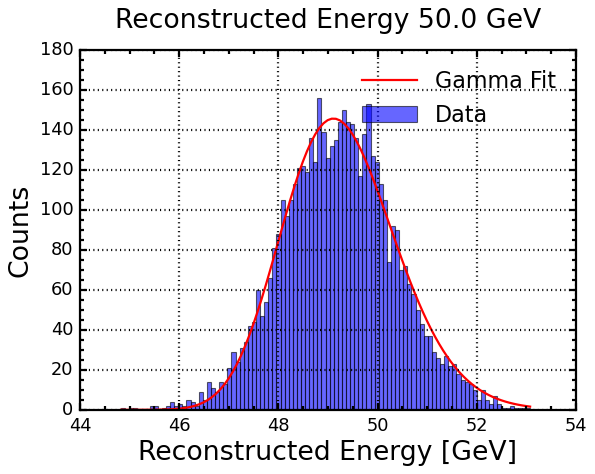

appending results for E = 50.0
Mean_Gamma: 49.29585831517842 Mean_Gamma_Error: 0.025255688102310485
Peak_Gamma: 49.11223576771243 Peak_Gamma_Error: 0.024945588546887693
Mean: 58.29606720190121, Peak: 58.31463954607944, RMS: 1.1958124802969161
Initial Gamma Fit Parameters: [np.float64(526.0059318159318), np.float64(4.869015833009729), np.float64(52.47363730202489), np.float64(1.1958124802969161)]
Gamma Fit Bounds: lower [np.float64(5.2600593181593185), np.float64(-0.5130984166990271), np.float64(4.24736373020249), np.float64(0.11958124802969161)], 
 upper [np.float64(3156.0355908955908), np.float64(48.69015833009729), np.float64(88.71045595303734), np.float64(11.958124802969161)]
Gamma Fit Parameters: [5.26143554e+02 4.86901583e+01 4.99774606e+01 1.72473956e-01]
Gamma Fit Peak: 58.20277086072527 ± 0.02350002086779358, Mean: 58.37524481632154 ± 0.02370092951337097, Resolution: 0.020677615556105554 ± 0.0002753234317832134


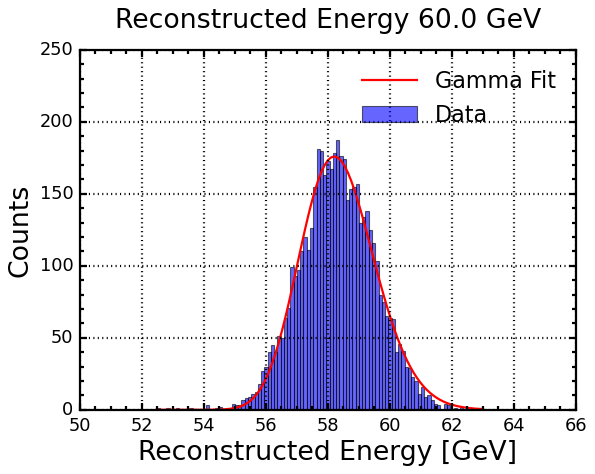

appending results for E = 60.0
Mean_Gamma: 58.37524481632154 Mean_Gamma_Error: 0.02370092951337097
Peak_Gamma: 58.20277086072527 Peak_Gamma_Error: 0.02350002086779358


In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN_Hits_{CONF_NAME}_Fit.csv")
print(f"Saving fit results to {outputfile_name}")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")